## loading stuff
- na primeira vez do 'runtime' tem que instalar odc-ui e rasterstats
- 

In [1]:
!pip install odc-ui rasterstats

In [1]:
import time
start = time.time()


In [2]:
%%time
# the basic
#import rich.table

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

# for PC, stac, xarray
import odc.stac
import stackstac
from xrspatial import zonal_stats

# From DEA
import sys
sys.path.append('/home/jovyan/PlanetaryComputerExamples/CODE/grits/deafrica_tools/')
from plotting import display_map, rgb, map_shapefile

# packages that have to be installed every runtime
import subprocess
import pkg_resources

required = {'rasterstats','odc-ui'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

CPU times: user 2.28 s, sys: 776 ms, total: 3.05 s
Wall time: 17 s


In [3]:
import grits

## Getting the study area

In [4]:
path = '/home/jovyan/PlanetaryComputerExamples/vetorial/FAZENDAS/'

### Fazenda Uniguiri

#### a fazenda toda

In [ ]:
field = gpd.read_file( path + 'fazenda_uniguiri.gpkg')
bbox, lat_range, lon_range = get_lims(field)

print(field.head())
field.plot()

#### piquetes em uma região da fazenda
A fazenda é dividida em 4 regiões (column = 'Re') e dentro há os piquetes ('TID', o "talhão ID"). No .gpkg da fazenda_uniguiri temos o layer 'piquetes_tid' que contém todas as subdivisões da fazenda. 

No exemplo selecinei todos talhões da **Região 80000**

In [5]:
# para um grupo dentro de uma farm
layer = 'piquetes_tid'
column = 'Re'
val = 80000

field = gpd.read_file( path + 'fazenda_uniguiri.gpkg' , layer=layer)
field = field[field[column] == val]

bbox, lat_range, lon_range = grits.get_lims(field)

print(field.head())

# plotting a partir do TID
style={'opacity': 6, 'stroke': 2,'dashArray': '1', 'fillOpacity': 0.5}
map_shapefile(field,'TID',cmap='Set1', **style )

got bbox, lat_range, lon_range
    PID  area_ha    R   ID      SR     Re   Fi     TID  \
0  R8_4      6.4  R8_    4  100000  80000    4  180004   
1     F     10.6    F  NaN  100000  80000  901  180901   
2  R8_5      6.9  R8_    5  100000  80000    5  180005   
3     C      0.7    C  NaN  100000  80000  801  180801   
4  R8_1      6.7  R8_    1  100000  80000    1  180001   

                                            geometry  
0  MULTIPOLYGON (((-54.57526 -16.95986, -54.57705...  
1  MULTIPOLYGON (((-54.57224 -16.96252, -54.57131...  
2  MULTIPOLYGON (((-54.57705 -16.96167, -54.57526...  
3  MULTIPOLYGON (((-54.56787 -16.95268, -54.56744...  
4  MULTIPOLYGON (((-54.57109 -16.95544, -54.57249...  


Label(value='')

Map(center=[-16.955265352726073, -54.57066140325033], controls=(ZoomControl(options=['position', 'zoom_in_text…

### Iacanga - Usina Ipiranga
O shape da Usina Ipiranga em Iacanga (fornecido pelo Vanda). As áreas que fornecem para a usina estão organizadas em, creio que, fazendas com número e nome na coluna 'LAYER', por exemplo: '032 APARECIDA', '001 SAO JORGE'. 

Já os talhões estão numerados unicamente dentro do shape todo a partir da coluna 'AdMapKey'

In [ ]:
%%time

field = grits.get_field(path + 'iacanga_22_23.gpkg',
                 column = 'LAYER',
                 ID = '001 SAO JORGE',
                 layer = 'talhoes') #este é o layer do .gpkg

bbox, lat_range, lon_range = get_lims(field)

print(field.head())

style={'opacity': 6, 'stroke': 2,'dashArray': '1', 'fillOpacity': 0.5}
map_shapefile(field,'AdMapKey',cmap='Set1', **style )

## the Sentinel 2 pathway
1. Fazer a query para o período 'datetime' desejado e setar a cobertura máxima de nuvens. 
2. Montar o datacube (o xarray de dados) no modo **lazy**

In [6]:
datetime = "2017-07-10/2023-10-10"
max_cloud_cover = 30
items = grits.query_l2a_items(bbox, datetime, max_cloud_cover)

 found 215 items


In [7]:
# For Sentinel 2
data = (
    stackstac.stack(
        items,
        assets = ["B11","B12","B08","B06", "B04", "B03","B02", "SCL"], 
        chunksize=256,
        epsg=4326,
        bounds=bbox,
        properties = True,
        fill_value = np.nan,
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)

# fix xy names
data = data.rename({'x': 'longitude','y': 'latitude'})
data

<xarray.DataArray 'stackstac-4967890491f48863ed11db828ffe31f8' (time: 215,
                                                                band: 8,
                                                                latitude: 173,
                                                                longitude: 161)>
dask.array<where, shape=(215, 8, 173, 161), dtype=float64, chunksize=(1, 1, 173, 161), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2017-07-13...
    id                                       (time) <U54 'S2A_MSIL2A_20170713...
  * band                                     (band) object 'swir16' ... None
  * longitude                                (longitude) float64 -54.58 ... -...
  * latitude                                 (latitude) float64 -16.95 ... -1...
    s2:thin_cirrus_percentage                (time) float64 0.003968 ... 1.775
    ...                                       ...
    gsd                                      (band) float64 20.0 20.0 ... 20.0
    title                                    (band) <U36 'Band 11 - SWIR (1.6...
    common_name                              (band) object 'swir16' ... None
    center_wavelength                        (band) object 1.61 2.19 ... None
    full_width_half_max                      (band) object 0.143 0.242 ... None
    epsg                                     int64 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-54.57825604339398, -16.963...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-54.58|\n| 0.00,-0.00,-16.95|\n| 0.00, 0.00,...
    resolution_xy:  (9.439942722622163e-05, 9.118049409906348e-05)

### masking farm and creating zones
São dois passos, mascarar a parte de fora da fazenda e criar o raster com as zonas de análise numeradas em int (**checar se há uma limitação de 100 features**)

In [8]:
#create MASK versao dataarray
masked = True

if masked:
    mask = grits.xr_rasterize(field,data,
                        # x_dim='x',
                        # y_dim='y',
                       #export_tiff='masked2.tiff',
                       ) 

    # #mask data
    data = data.where(mask)

    # #convert to float 32 to conserve memory
    data = data.astype(np.float32)
data

<xarray.DataArray 'stackstac-4967890491f48863ed11db828ffe31f8' (time: 215,
                                                                band: 8,
                                                                latitude: 173,
                                                                longitude: 161)>
dask.array<astype, shape=(215, 8, 173, 161), dtype=float32, chunksize=(1, 1, 173, 161), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2017-07-13...
    id                                       (time) <U54 'S2A_MSIL2A_20170713...
  * band                                     (band) object 'swir16' ... None
  * longitude                                (longitude) float64 -54.58 ... -...
  * latitude                                 (latitude) float64 -16.95 ... -1...
    s2:thin_cirrus_percentage                (time) float64 0.003968 ... 1.775
    ...                                       ...
    gsd                                      (band) float64 20.0 20.0 ... 20.0
    title                                    (band) <U36 'Band 11 - SWIR (1.6...
    common_name                              (band) object 'swir16' ... None
    center_wavelength                        (band) object 1.61 2.19 ... None
    full_width_half_max                      (band) object 0.143 0.242 ... None
    epsg                                     int64 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-54.57825604339398, -16.963...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-54.58|\n| 0.00,-0.00,-16.95|\n| 0.00, 0.00,...
    resolution_xy:  (9.439942722622163e-05, 9.118049409906348e-05)

### calcular índices
Há várias opções de índices e não tem problema carregar muitas bandas no modo lazy. Optei pelo Leaf Area Index (LAI), Enhanced Vegetation Index (EVI), Normalized Difference Chrolophyl Index (NDCI) e o Bare Soil Index (BSI). Os dois primeiros tento relacionar com biomassa, já o NDCI com a qualidade da biomassa e o BSI com a ausência de biomassa.

In [9]:
# converte o dataarray em dataset
ds_ = data.to_dataset(dim='band') 

# calcula os indices
indices = ["LAI", "EVI","NDCI", "BSI"]
ds = grits.calculate_indices(ds_, 
                       index= indices, 
                       satellite_mission='s2', 
                       drop=True);

grits.humanbytes(ds.nbytes)

Dropping bands ['swir16', 'swir22', 'nir', 'rededge', 'red', 'green', 'blue', None]


'91.67 MB'

### calcular Z-scores
A partir da série temporal, calcular os z-scores baseado em **mean** e **std** mensais.

In [10]:
zscores = grits.zscore_dataset(ds)
grits.humanbytes(zscores.nbytes)

'91.67 MB'

### not so quick diagnostics
Setar os percentis máximos e mínimos para os plots

In [ ]:
%%time
# para os IVs
qmin_qmax=[0.02, 0.98]
mms = grits.get_mms(ds, indices, qmin_qmax)

In [11]:
%%time
# para os ZSCORES
qmin_qmax=[0.02, 0.98]
mms = grits.get_mms(zscores, indices, qmin_qmax)

{'LAI': array([-1.66987398,  2.12897914]), 'EVI': array([-1.66987395,  2.12897944]), 'NDCI': array([-1.73089138,  2.27731355]), 'BSI': array([-2.10725167,  1.85845889])}
CPU times: user 41.5 s, sys: 10.2 s, total: 51.7 s
Wall time: 35 s


### plotting zscores
**XXXXXXX PROBLEMAS Quando SLICEIA, dá pau lá pro final, não entendi.**

In [12]:
i1,i2,i3 = 'NDCI','BSI','LAI'

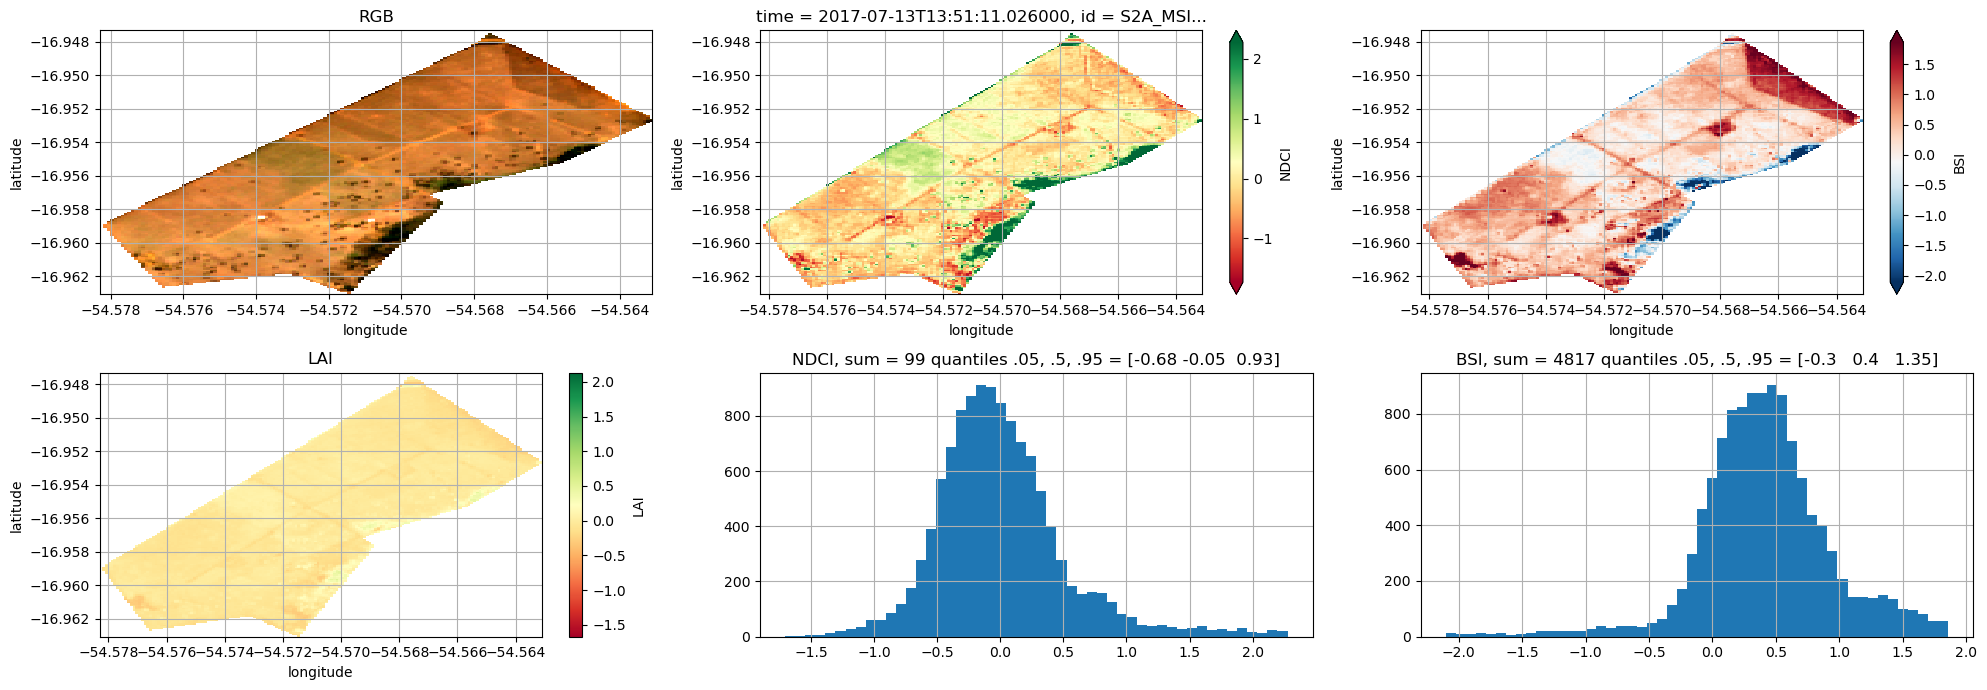

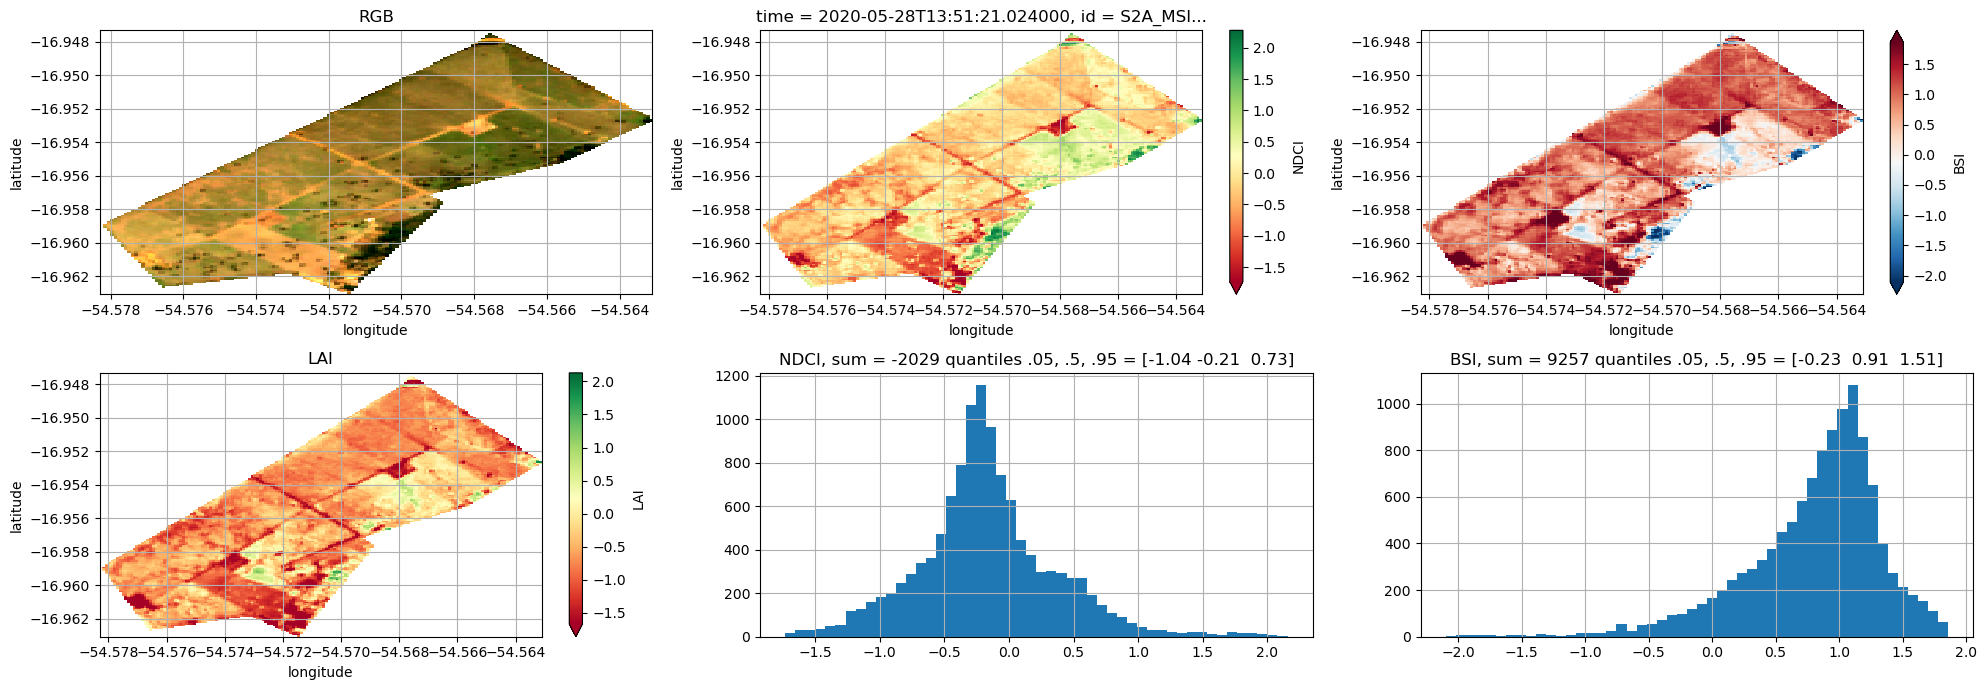

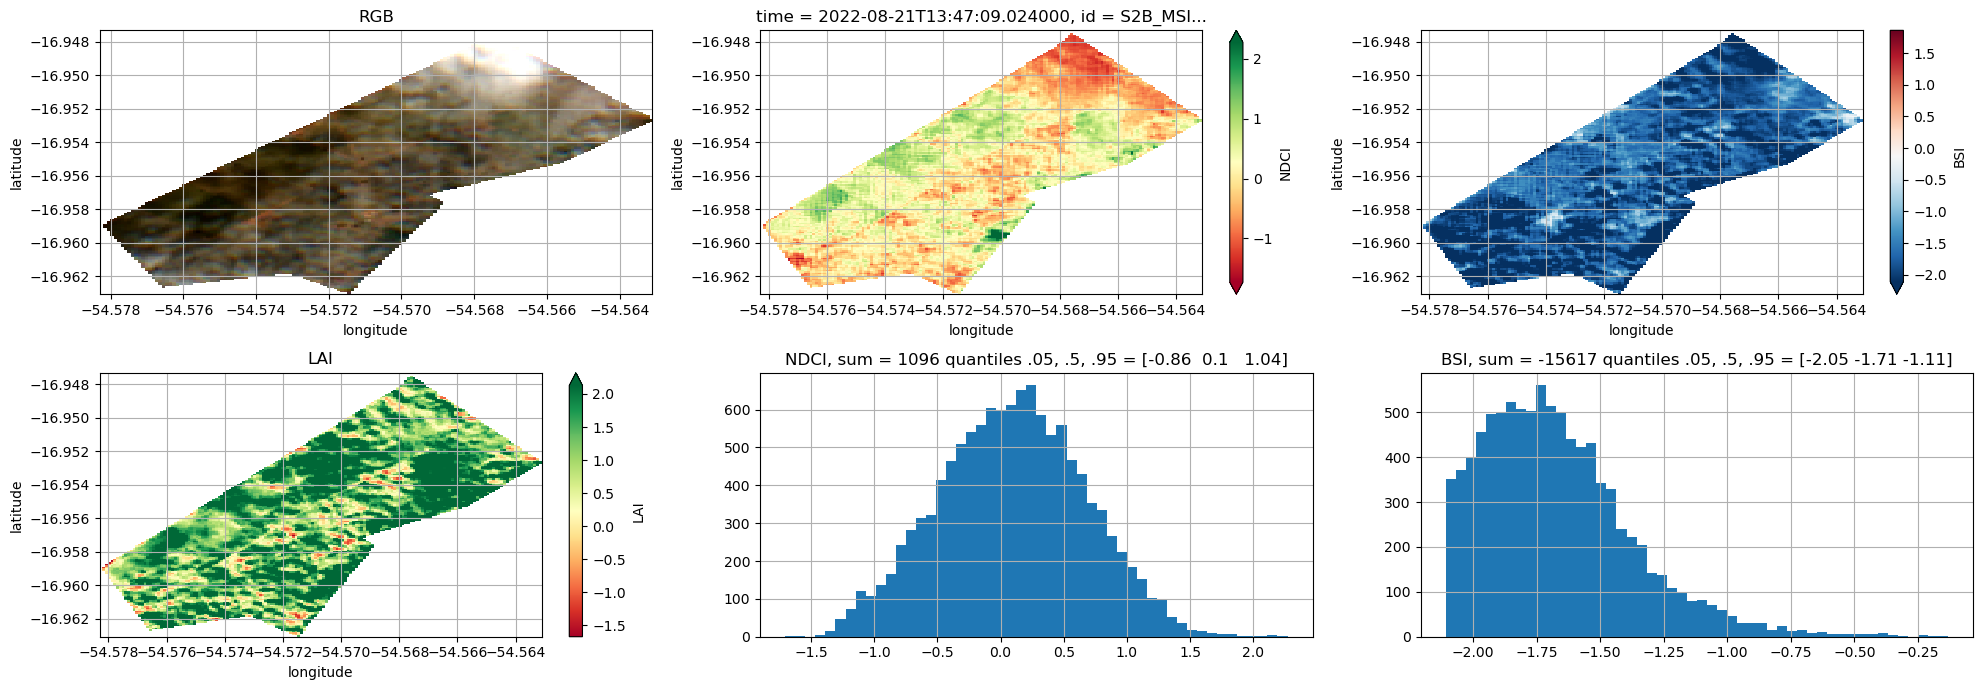

In [18]:
# plot ZSCORES using time slice
timeslice = False

if timeslice:
    zscores_ = zscores.sel(time=slice("2023-06-15", "2023-07-31")).copy(deep=True)
    step = 1
    
if not timeslice:
    zscores_ = zscores.copy()
    step = 90


for t in range(0, len(zscores.time),step):

    fig, ((ax1,ax2,ax3), (ax4,ax5,ax6))  = plt.subplots(2, 3,figsize=(20,7))

    # RGB
    rgb(ds_,index=[t],percentile_stretch=(0.02,0.98), ax=ax1, aspect=1)
    ax1.set_title('RGB')
    ax1.grid()

    # i1 plot
    zscores_[i1].isel(time=[t]).plot(cmap = 'RdYlGn', vmin = mms[i1][0], vmax = mms[i1][1], ax=ax2)
    ax2.grid()

    # i1 histogram
    flat = zscores_[i1].isel(time=[t]).values.flatten()
    flat = np.where((flat > mms[i1][1]) | (flat < mms[i1][0]), np.nan, flat)
    ax5.hist(flat,50)
    ax5.grid()
    ax5.set_title(f'{i1}, sum = {np.nansum(flat):.0f} quantiles .05, .5, .95 = {np.round(np.nanquantile(flat,[.05,.5,.95]),2)}')

    # i2 plot
    # por ser 'BSI', uso a escala invertida
    zscores_[i2].isel(time=[t]).plot(cmap = 'RdBu_r', vmin = mms[i2][0], vmax = mms[i2][1], ax=ax3)
    ax3.set_title(None);
    ax3.grid()

    # i2 histogram
    flat = zscores_[i2].isel(time=[t]).values.flatten()
    flat = np.where((flat > mms[i2][1]) | (flat < mms[i2][0]), np.nan, flat)
    ax6.hist(flat, bins=50)
    ax6.grid()
    ax6.set_title(f'{i2}, sum = {np.nansum(flat):.0f} quantiles .05, .5, .95 = {np.round(np.nanquantile(flat,[.05,.5,.95]),2)}')

    # i3 plot
    zscores_[i3].isel(time=[t]).plot(cmap = 'RdYlGn', vmin = mms[i3][0], vmax = mms[i3][1], ax=ax4)
    ax4.set_title(i3);
    ax4.grid()

    fig.tight_layout();   
    plt.show();plt.close()

### Plotting regular IVs time-series

In [ ]:
step = 50
t = 1

for t in range(0, len(ds_.time),step):
    fig, ((ax1,ax2,ax3), (ax4,ax5,ax6))  = plt.subplots(2, 3,figsize=(20,7))

    rgb(ds_,index=[t],percentile_stretch=(0.02,0.98), ax=ax1, aspect=1)
    ax1.set_title(None)
    ax1.grid()

    ds[i1].isel(time=[t]).plot(cmap = 'RdYlGn', vmin = mms[i1][0], vmax = mms[i1][1], ax=ax2)
    ax2.grid()

    flat = ds[i1].isel(time=[t]).values.flatten()
    flat = np.where((flat> 3.5) | (flat<0), np.nan, flat)
    ax5.hist(flat,50)
    ax5.grid()
    ax5.set_title(f'{i1}, sum = {np.nansum(flat):.0f} quantiles .05, .5, .95 = {np.round(np.nanquantile(flat,[.05,.5,.95]),2)}')

    ds[i2].isel(time=[t]).plot(cmap = 'RdYlGn', vmin = mms[i2][0], vmax = mms[i2][1], ax=ax3)
    ax3.set_title(None);
    ax3.grid()


    flat = ds[i2].isel(time=[t]).values.flatten()
    flat = np.where((flat> 3.5) | (flat<0), np.nan, flat)
    ax6.hist(flat, bins=50)
    ax6.grid()
    ax6.set_title(f'{i2}, sum = {np.nansum(flat):.0f} quantiles .05, .5, .95 = {np.round(np.nanquantile(flat,[.05,.5,.95]),2)}')

    ds[i3].isel(time=[t]).plot(cmap = 'RdYlGn', vmin = mms[i3][0], vmax = mms[i3][1], ax=ax4)
    ax4.set_title(None);
    ax4.grid()

    fig.tight_layout();   
    plt.show();plt.close()